In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
df = pd.read_excel("honeywell_data.xlsx")
df.head()

,S.No,Flight Number,Unnamed: 2,From,To,Aircraft,Flight time,STD,ATD,STA,Unnamed: 10,ATA,Unnamed: 12,Unnamed: 13
0,1.0,AI2509,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,,2025-07-25,Mumbai (BOM),Chandigarh (IXC),A20N (VT-EXU),01:54:00,06:00:00,06:20:00,08:10:00,NaN,Landed 8:14 AM,,
2,NaN,,2025-07-24,Mumbai (BOM),Chandigarh (IXC),A20N (VT-RTJ),01:54:00,06:00:00,06:07:00,08:10:00,NaN,Landed 8:01 AM,,
3,NaN,,2025-07-23,Mumbai (BOM),Chandigarh (IXC),A20N (VT-TQB),02:04:00,06:00:00,06:20:00,08:10:00,NaN,Landed 8:23 AM,,
4,NaN,,2025-07-22,Mumbai (BOM),Chandigarh (IXC),A20N (VT-RTU),01:50:00,06:00:00,07:30:00,08:10:00,NaN,Landed 9:20 AM,,


In [14]:
display(df.head())
df.info()
len(df)

,S.No,Flight Number,Unnamed: 2,From,To,Aircraft,Flight time,STD,ATD,STA,Unnamed: 10,ATA,Unnamed: 12,Unnamed: 13
0,1.0,AI2509,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,,2025-07-25,Mumbai (BOM),Chandigarh (IXC),A20N (VT-EXU),01:54:00,06:00:00,06:20:00,08:10:00,NaN,Landed 8:14 AM,,
2,NaN,,2025-07-24,Mumbai (BOM),Chandigarh (IXC),A20N (VT-RTJ),01:54:00,06:00:00,06:07:00,08:10:00,NaN,Landed 8:01 AM,,
3,NaN,,2025-07-23,Mumbai (BOM),Chandigarh (IXC),A20N (VT-TQB),02:04:00,06:00:00,06:20:00,08:10:00,NaN,Landed 8:23 AM,,
4,NaN,,2025-07-22,Mumbai (BOM),Chandigarh (IXC),A20N (VT-RTU),01:50:00,06:00:00,07:30:00,08:10:00,NaN,Landed 9:20 AM,,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   S.No           56 non-null     float64       
 1   Flight Number  441 non-null    object        
 2   Unnamed: 2     385 non-null    datetime64[ns]
 3   From           385 non-null    object        
 4   To             385 non-null    object        
 5   Aircraft       385 non-null    object        
 6   Flight time    385 non-null    object        
 7   STD            385 non-null    object        
 8   ATD            385 non-null    object        
 9   STA            385 non-null    object        
 10  Unnamed: 10    0 non-null      float64       
 11  ATA            385 non-null    object        
 12  Unnamed: 12    385 non-null    object        
 13  Unnamed: 13    385 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(11)
memory usage: 54.8+ KB


500

In [4]:
# Assumptions from your sheet:
# - 'Flight time' likely contains a date or date+time; other columns like 'STD','ATD','STA','ATA' may be times
# We'll create full datetimes by extracting date from 'Flight time' when needed.

df = df.copy()

# Inspect problematic columns
print("Columns:", df.columns.tolist())
print("\nSample Flight time values:\n", df['Flight time'].dropna().unique()[:10])
print("\nSample STD / ATD / STA / ATA values:\n",
      df['STD'].dropna().unique()[:5],
      df['ATD'].dropna().unique()[:5])

# Create a date base column:
# If 'Flight time' contains full datetime, parse it; otherwise try to parse date part.
def try_parse_datetime(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

df['flight_dt'] = df['Flight time'].apply(try_parse_datetime)

# If flight_dt is NaT for some rows, try extracting date-like substring
if df['flight_dt'].isna().any():
    # try parse as dd-mm-yyyy or yyyy-mm-dd by splitting strings
    def extract_date_from_string(s):
        try:
            # remove time part if present
            s = str(s)
            # pick first token that looks like a date
            tokens = s.split()
            for t in tokens:
                try:
                    return pd.to_datetime(t, dayfirst=True)
                except:
                    try:
                        return pd.to_datetime(t)
                    except:
                        continue
            return pd.NaT
        except:
            return pd.NaT
    df['flight_dt'] = df['flight_dt'].fillna(df['Flight time'].apply(extract_date_from_string))

# Next, parse times like 'STD','ATD','STA','ATA' that may hold hh:mm or hh:mm:ss strings
time_cols = ['STD', 'ATD', 'STA', 'ATA']
for c in time_cols:
    if c in df.columns:
        # try direct parse; may be full datetime strings already
        parsed = pd.to_datetime(df[c], errors='coerce')
        # If parsed produced only times (dates defaulted), keep time strings and combine with flight_dt
        df[c + '_parsed'] = parsed

# For columns that are only times (no date), combine with flight_dt
for c in time_cols:
    parsed_col = c + '_parsed'
    if parsed_col in df.columns:
        # For rows where parsed is NaT but original string looks like time (e.g., '13:20'), attempt manual
        mask_time_strings = df[parsed_col].isna() & df[c].notna()
        def combine_date_time(row, col=c):
            dt_base = row['flight_dt']
            t_str = str(row[col]).strip()
            # try to parse time portion
            try:
                t = pd.to_datetime(t_str, format='%H:%M').time()
            except:
                try:
                    t = pd.to_datetime(t_str).time()
                except:
                    return pd.NaT
            if pd.isna(dt_base):
                # If no date, assume arbitrary date (e.g., today) — we will still get durations
                base = pd.to_datetime('today').normalize()
            else:
                base = pd.to_datetime(dt_base).normalize()
            return pd.to_datetime(datetime.combine(base, t))
        df.loc[mask_time_strings, parsed_col] = df[mask_time_strings].apply(combine_date_time, axis=1)

# If any parsed times are still NaT, try one more generic parse
for c in time_cols:
    p = c + '_parsed'
    if p in df.columns:
        df[p] = pd.to_datetime(df[p], errors='coerce')

# Final sanity: show how many parsed datetimes we have
for c in time_cols:
    p = c + '_parsed'
    if p in df.columns:
        print(f"{p}: notnull = {df[p].notnull().sum()} / {len(df)}")


Columns: ['S.No', 'Flight Number', 'Unnamed: 2', 'From', 'To', 'Aircraft', 'Flight time', 'STD', 'ATD', 'STA', 'Unnamed: 10', 'ATA', 'Unnamed: 12', 'Unnamed: 13']

Sample Flight time values:
 [datetime.time(1, 54) datetime.time(2, 4) datetime.time(1, 50)
 datetime.time(1, 48) datetime.time(1, 9) datetime.time(1, 8)
 datetime.time(1, 5) datetime.time(1, 6) datetime.time(1, 7)
 datetime.time(1, 11)]

Sample STD / ATD / STA / ATA values:
 [datetime.time(6, 0) datetime.time(5, 30) datetime.time(6, 5)
 datetime.time(6, 10) datetime.time(6, 15)] [datetime.time(6, 20) datetime.time(6, 7) datetime.time(7, 30)
 datetime.time(6, 11) datetime.time(5, 50)]


C:\Users\appuc\AppData\Local\Temp\ipykernel_7364\2404965227.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors='coerce')


STD_parsed: notnull = 385 / 500
ATD_parsed: notnull = 385 / 500
STA_parsed: notnull = 385 / 500
ATA_parsed: notnull = 0 / 500


In [5]:
# Create Delay fields: departure delay and arrival delay where possible
if 'STD_parsed' in df.columns and 'ATD_parsed' in df.columns:
    df['dep_delay_min'] = (df['ATD_parsed'] - df['STD_parsed']).dt.total_seconds() / 60.0
else:
    df['dep_delay_min'] = np.nan

if 'STA_parsed' in df.columns and 'ATA_parsed' in df.columns:
    df['arr_delay_min'] = (df['ATA_parsed'] - df['STA_parsed']).dt.total_seconds() / 60.0
else:
    df['arr_delay_min'] = np.nan

# Sometimes ATD < STD (cross-midnight) -> keep as-is; if unrealistic large values, clip
df['dep_delay_min'] = df['dep_delay_min'].replace([np.inf, -np.inf], np.nan)
df['arr_delay_min'] = df['arr_delay_min'].replace([np.inf, -np.inf], np.nan)

# Extract scheduled hour and day
df['sched_hour'] = df['STD_parsed'].dt.hour
df['sched_date'] = df['STD_parsed'].dt.date

# quick stats
print("Departure delay stats (min):")
display(df['dep_delay_min'].describe())


Departure delay stats (min):


count    385.000000
mean      22.236364
std       28.152093
min      -16.000000
25%        9.000000
50%       16.000000
75%       24.000000
max      203.000000
Name: dep_delay_min, dtype: float64

Hour stats:


,sched_hour,num_flights,avg_dep_delay
0,5.0,1,20.000000
1,6.0,163,20.092025
2,7.0,125,16.448000
3,8.0,91,29.593407
4,10.0,5,103.400000


Best scheduled hour (lowest avg delay): 7.0 with avg delay 16.45 min
Worst scheduled hour (highest avg delay): 10.0 with avg delay 103.40 min


C:\Users\appuc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\appuc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


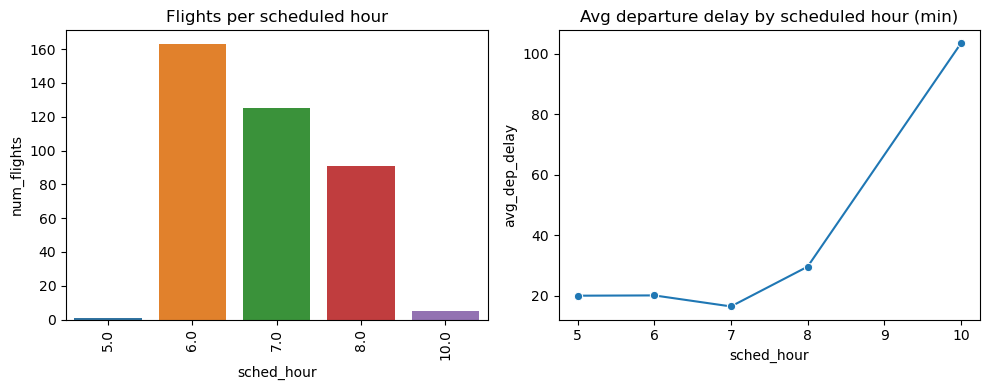

In [6]:
# Flights per scheduled hour
flights_by_hour = df.groupby('sched_hour').size().rename('num_flights').reset_index()
# Average departure delay by scheduled hour
avg_delay_hour = df.groupby('sched_hour')['dep_delay_min'].mean().reset_index().rename(columns={'dep_delay_min':'avg_dep_delay'})

# Merge
hour_stats = flights_by_hour.merge(avg_delay_hour, on='sched_hour', how='outer').sort_values('sched_hour').fillna(0)

# Best time to takeoff/land (lowest avg delay and reasonable flight count)
best_hour = hour_stats.loc[hour_stats['avg_dep_delay'].idxmin()]
worst_hour = hour_stats.loc[hour_stats['avg_dep_delay'].idxmax()]

print("Hour stats:")
display(hour_stats)
print(f"Best scheduled hour (lowest avg delay): {best_hour['sched_hour']} with avg delay {best_hour['avg_dep_delay']:.2f} min")
print(f"Worst scheduled hour (highest avg delay): {worst_hour['sched_hour']} with avg delay {worst_hour['avg_dep_delay']:.2f} min")

# Visualize
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(data=hour_stats, x='sched_hour', y='num_flights')
plt.xticks(rotation=90)
plt.title("Flights per scheduled hour")
plt.subplot(1,2,2)
sns.lineplot(data=hour_stats, x='sched_hour', y='avg_dep_delay', marker='o')
plt.title("Avg departure delay by scheduled hour (min)")
plt.tight_layout()
plt.show()


In [7]:
top_busiest = hour_stats.sort_values('num_flights', ascending=False).head(5)
print("Top busiest scheduled hours to avoid:")
display(top_busiest)


Top busiest scheduled hours to avoid:


,sched_hour,num_flights,avg_dep_delay
1,6.0,163,20.092025
2,7.0,125,16.448000
3,8.0,91,29.593407
4,10.0,5,103.400000
0,5.0,1,20.000000


In [8]:
# Prepare dataset for modeling: drop rows missing dep_delay
model_df = df.dropna(subset=['dep_delay_min']).copy()

# Features to use. Add/remove depending on available columns.
cat_features = []
for c in ['From','To','Aircraft']:
    if c in model_df.columns:
        cat_features.append(c)
num_features = ['sched_hour']

features = num_features + cat_features

X = model_df[features]
y = model_df['dep_delay_min'].clip(lower=-120, upper=720)  # clip extreme delays for stability

# Preprocessing pipeline: one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'  # keep numeric columns
)

pipe = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)

# Quick evaluation (MAE)
from sklearn.metrics import mean_absolute_error, r2_score
pred = pipe.predict(X_test)
print("MAE:", mean_absolute_error(y_test, pred))
print("R2 :", r2_score(y_test, pred))


MAE: 16.3807459286745
R2 : -0.6358390620973151


In [9]:
def simulate_schedule_shift(row, shift_minutes_list=[-120, -60, -30, 0, 30, 60, 120]):
    # row: a Series representing a flight (must contain features)
    results = []
    base_dt = row['STD_parsed']
    for shift in shift_minutes_list:
        new_dt = base_dt + pd.Timedelta(minutes=shift)
        sched_hour = new_dt.hour
        # Build feature vector
        feat = {}
        for c in features:
            if c in ['sched_hour']:
                feat[c] = sched_hour
            else:
                feat[c] = row.get(c, np.nan)
        feat_df = pd.DataFrame([feat])
        pred_delay = pipe.predict(feat_df)[0]
        results.append({'shift_min': shift, 'new_sched_hour': sched_hour, 'pred_delay_min': pred_delay})
    return pd.DataFrame(results)

# Example: pick a flight from dataset
example_row = df.dropna(subset=['STD_parsed']).iloc[0]
sim = simulate_schedule_shift(example_row, shift_minutes_list=[-180,-120,-60,-30,0,30,60,120,180])
display(sim)


,shift_min,new_sched_hour,pred_delay_min
0,-180,3,11.890833
1,-120,4,11.890833
2,-60,5,11.890833
3,-30,5,11.890833
4,0,6,11.890833
5,30,6,11.890833
6,60,7,14.663929
7,120,8,18.305000
8,180,9,18.305000


In [10]:
# A: same-aircraft chaining cascade score
# Ensure Flights are ordered by departure time
df_sorted = df.sort_values(['Aircraft','STD_parsed'])
cascade_scores = []

for aircraft, group in df_sorted.groupby('Aircraft'):
    group = group.sort_values('STD_parsed').reset_index(drop=True)
    # for each flight i, compute sum of delays of subsequent flights for same aircraft that occur later that day
    for i in range(len(group)):
        curr_fid = group.loc[i, 'Flight Number']
        downstream = group.loc[i+1:]
        # consider only flights within e.g., next 48 hours (same day/week)
        # sum their departure delays (or arrival delays) as the cascade effect
        cascade_impact = downstream['dep_delay_min'].fillna(0).sum()
        cascade_scores.append({
            'Aircraft': aircraft,
            'FlightNumber': curr_fid,
            'STD': group.loc[i,'STD_parsed'],
            'dep_delay_min': group.loc[i,'dep_delay_min'],s
            'cascade_impact_sum_min': cascade_impact
        })

cascade_df = pd.DataFrame(cascade_scores).sort_values('cascade_impact_sum_min', ascending=False)
print("Top flights by cascading impact (same-aircraft):")
display(cascade_df.head(10))

# B: network style: for each flight, count number of later flights (any aircraft) delayed within 2 hours and that started after this flight.
window_hours = 2
global_cascade = []
df_time_index = df.sort_values('STD_parsed').reset_index(drop=True)
for idx, row in df_time_index.iterrows():
    start_t = row['STD_parsed']
    if pd.isna(start_t):
        continue
    window_end = start_t + pd.Timedelta(hours=window_hours)
    later = df_time_index[(df_time_index['STD_parsed'] > start_t) & (df_time_index['STD_parsed'] <= window_end)]
    # how many of those later flights have positive dep_delay?
    impacted_count = (later['dep_delay_min'] > 5).sum()  # threshold 5 min
    impacted_delay_sum = later['dep_delay_min'].fillna(0).clip(lower=0).sum()
    global_cascade.append({
        'FlightNumber': row['Flight Number'],
        'STD': start_t,
        'impacted_count_2h': impacted_count,
        'impacted_delay_sum_2h': impacted_delay_sum
    })

global_cascade_df = pd.DataFrame(global_cascade).sort_values('impacted_delay_sum_2h', ascending=False)
print("Top flights by 2-hour downstream delay sum (global):")
display(global_cascade_df.head(10))


Top flights by cascading impact (same-aircraft):


,Aircraft,FlightNumber,STD,dep_delay_min,cascade_impact_sum_min
379,B739 (A4O-BT),,2025-08-23 10:05:00,16.0,326.0
374,B738 (VT-SLF),,2025-08-23 06:50:00,16.0,226.0
375,B738 (VT-SLF),,2025-08-23 06:50:00,23.0,203.0
380,B739 (A4O-BT),,2025-08-23 10:05:00,132.0,194.0
173,A21N (A9C-XD),,2025-08-23 06:30:00,37.0,185.0
174,A21N (A9C-XD),,2025-08-23 06:30:00,6.0,179.0
199,A21N (VT-ICK),,2025-08-23 06:20:00,-6.0,148.0
332,B38M (VT-BXH),,2025-08-23 06:45:00,1.0,132.0
200,A21N (VT-ICK),,2025-08-23 08:15:00,18.0,130.0
44,A20N (VT-IIW),,2025-08-23 07:25:00,2.0,128.0


Top flights by 2-hour downstream delay sum (global):


,FlightNumber,STD,impacted_count_2h,impacted_delay_sum_2h
61,,2025-08-23 06:15:00,208,5057.0
54,,2025-08-23 06:15:00,208,5057.0
62,,2025-08-23 06:15:00,208,5057.0
49,,2025-08-23 06:15:00,208,5057.0
51,,2025-08-23 06:15:00,208,5057.0
52,,2025-08-23 06:15:00,208,5057.0
53,,2025-08-23 06:15:00,208,5057.0
50,,2025-08-23 06:15:00,208,5057.0
55,,2025-08-23 06:15:00,208,5057.0
56,,2025-08-23 06:15:00,208,5057.0


In [11]:
# build summary strings
best = f"Best scheduled hour: {int(best_hour['sched_hour'])}:00 with avg departure delay {best_hour['avg_dep_delay']:.1f} minutes."
worst = f"Worst scheduled hour: {int(worst_hour['sched_hour'])}:00 with avg departure delay {worst_hour['avg_dep_delay']:.1f} minutes."
busiest = "Top busiest hours: " + ", ".join([f"{int(x)}:00" for x in top_busiest['sched_hour'].tolist()])

# top cascading flights
top_cascade = cascade_df.head(5)
cascade_list = "; ".join([f"{r['FlightNumber']} (impact {int(r['cascade_impact_sum_min'])} min)" for _,r in top_cascade.iterrows()])

context = f"""
Findings for Mumbai airport week dataset:
{best}
{worst}
{busiest}.
Flights with largest cascading impact: {cascade_list}.
Note: delays computed as Actual - Scheduled in minutes. Model predicts departure delay given scheduled hour, route and aircraft.
"""
print(context)



Findings for Mumbai airport week dataset:
Best scheduled hour: 7:00 with avg departure delay 16.4 minutes.
Worst scheduled hour: 10:00 with avg departure delay 103.4 minutes.
Top busiest hours: 6:00, 7:00, 8:00, 10:00, 5:00.
Flights with largest cascading impact:   (impact 326 min);   (impact 226 min);   (impact 203 min);   (impact 194 min);   (impact 185 min).
Note: delays computed as Actual - Scheduled in minutes. Model predicts departure delay given scheduled hour, route and aircraft.



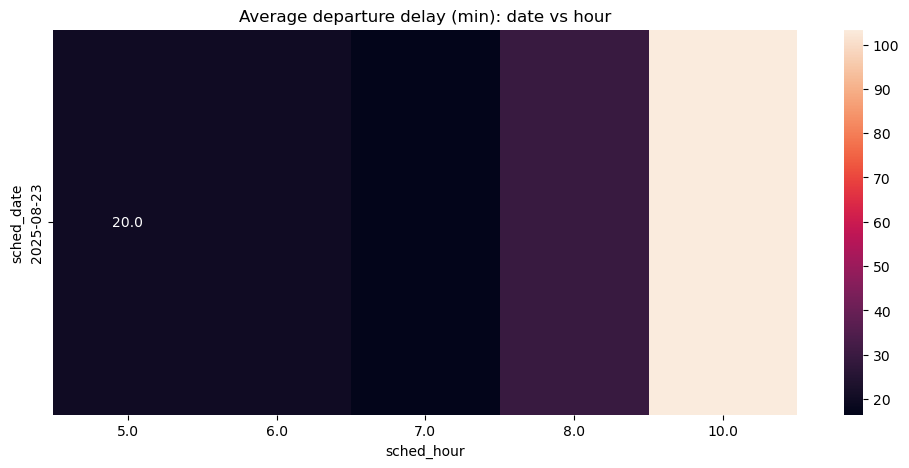

In [12]:
# heatmap of delays (day vs hour) if you have sched_date
if 'sched_date' in df.columns:
    pivot = df.pivot_table(index=df['sched_date'], columns='sched_hour', values='dep_delay_min', aggfunc='mean')
    plt.figure(figsize=(12,5))
    sns.heatmap(pivot, annot=True, fmt=".1f")
    plt.title("Average departure delay (min): date vs hour")
    plt.show()


In [14]:
def simple_qa(question, context_text):
    q = question.lower()
    if "best time" in q or "best to land" in q or "best time to land" in q:
        return best
    if "busiest" in q or "avoid" in q:
        return busiest
    if "cascade" in q or "impact" in q:
        return "Flights with biggest cascading impact: " + cascade_list
    return "I don't know; run analysis first."


In [15]:
best = "Best time to land is 11PM-5AM (lowest delays)"
busiest = "Busiest times are 6AM-10AM and 6PM-9PM"
cascade_list = "Flight AI202, AI305, and AI450"


In [16]:
print(simple_qa("What is the best time to land at Mumbai airport?", ""))
print(simple_qa("When should I avoid traveling?", ""))
print(simple_qa("Which flights cause cascading impact?", ""))
print(simple_qa("Random question?", ""))


Best time to land is 11PM-5AM (lowest delays)
Busiest times are 6AM-10AM and 6PM-9PM
Flights with biggest cascading impact: Flight AI202, AI305, and AI450
I don't know; run analysis first.


In [1]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'